# 📊 DNSSEC Extended Analysis Notebook

Este notebook analiza el archivo `resultados.json` generado por tu herramienta de auditoría DNSSEC.

Incluye:
- Lectura y validación del archivo JSON
- Clasificación de cada dominio según su estado DNSSEC
- Identificación de dominios seguros, inseguros y con errores
- Clasificación por **sector** (gobierno, educación, bancos, telcos, retail, etc.)
- Gráficas del ecosistema DNSSEC (barras y proporciones)
- Distribución de algoritmos criptográficos usados
- Chequeos simples de TTL para detectar posibles misconfiguraciones


In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

## 1. 🔍 Cargar archivo JSON

In [20]:
with open('resultados.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

len(data), data[0].get('domain')

(50, 'google.com.mx')

## 2. 🏷️ Clasificación del estado DNSSEC

Reglas de clasificación:

- `has_ds = True` y `chain_status = 'valid'` → **DNSSEC válido**
- `has_ds = True` y `chain_status = 'broken'` → **Cadena rota**
- Tiene `dnskey` pero no tiene DS → **Firmado sin DS (incompleto)**
- Sin DNSKEY y sin DS → **No DNSSEC**


In [21]:
def classify_dnssec(entry):
    ds = entry.get('ds_chain', {})
    dnskeys = entry.get('dnskey', [])

    if ds.get('has_ds') and ds.get('chain_status') == 'valid':
        return 'DNSSEC válido'
    if ds.get('has_ds') and ds.get('chain_status') == 'broken':
        return 'Cadena rota'
    if dnskeys and not ds.get('has_ds'):
        return 'Firmado sin DS (incompleto)'
    return 'No DNSSEC'

def classify_sector(domain: str) -> str:
    d = domain.lower()
    # Gobierno
    if '.gob.mx' in d:
        return 'Gobierno'
    # Educación superior
    edu_keywords = ['unam.mx', 'ipn.mx', 'tecmilenio.mx', 'itesm.mx', 'uam.mx', 'uanl.mx', 'udg.mx']
    if any(k in d for k in edu_keywords):
        return 'Educación'
    # Bancos comerciales
    bank_keywords = ['bbva.mx', 'santander.com.mx', 'banorte.com.mx', 'hsbc.com.mx']
    if any(k in d for k in bank_keywords):
        return 'Bancos'
    # Telcos / ISPs
    telco_keywords = ['telcel.com.mx', 'telmex.com.mx', 'megacable.com.mx', 'totalplay.com.mx', 'claro.com.mx', 'cfe.mx']
    if any(k in d for k in telco_keywords):
        return 'Telecom / ISP'
    # Retail / comercio
    retail_keywords = ['liverpool.com.mx', 'walmart.com.mx', 'soriana.com.mx', 'cinepolis.com.mx', 'cinemex.com.mx', 'mercadolibre.com.mx', 'amazon.com.mx']
    if any(k in d for k in retail_keywords):
        return 'Retail / Comercio'
    # Organismos financieros públicos / desarrollo
    if 'banxico.org.mx' in d or 'infonavit.org.mx' in d or 'conacyt.mx' in d:
        return 'Organismo público financiero / ciencia'
    # Empresa energética
    if 'pemex.com.mx' in d:
        return 'Energía / Empresa productiva'
    # Tecnología / otros
    if 'google.com.mx' in d or 'uber.com.mx' in d:
        return 'Tecnología / Servicios digitales'
    return 'Otros'

rows = []
for entry in data:
    domain = entry.get('domain')
    state = classify_dnssec(entry)
    sector = classify_sector(domain or '')
    ds = entry.get('ds_chain', {})
    dnskeys = entry.get('dnskey', [])
    algo_names = list({k.get('algorithm_name') for k in dnskeys}) if dnskeys else []
    rows.append({
        'Dominio': domain,
        'Estado DNSSEC': state,
        'Sector': sector,
        'Tiene DS': bool(ds.get('has_ds')),
        'chain_status': ds.get('chain_status'),
        'Algoritmos DNSKEY': ', '.join(algo_names) if algo_names else 'N/A'
    })

df = pd.DataFrame(rows)
df.head()

,Dominio,Estado DNSSEC,Sector,Tiene DS,chain_status,Algoritmos DNSKEY
0,google.com.mx,No DNSSEC,Tecnología / Servicios digitales,False,no_dnssec,N/A
1,gobierno.gob.mx,No DNSSEC,Gobierno,False,broken,N/A
2,sat.gob.mx,No DNSSEC,Gobierno,False,no_dnssec,N/A
3,imss.gob.mx,No DNSSEC,Gobierno,False,no_dnssec,N/A
4,issste.gob.mx,No DNSSEC,Gobierno,False,no_dnssec,N/A


## 3. 📊 Conteo por categoría de estado DNSSEC

In [22]:
state_counts = df['Estado DNSSEC'].value_counts()
state_counts

Estado DNSSEC
No DNSSEC                      43
Firmado sin DS (incompleto)     3
DNSSEC válido                   3
Cadena rota                     1
Name: count, dtype: int64

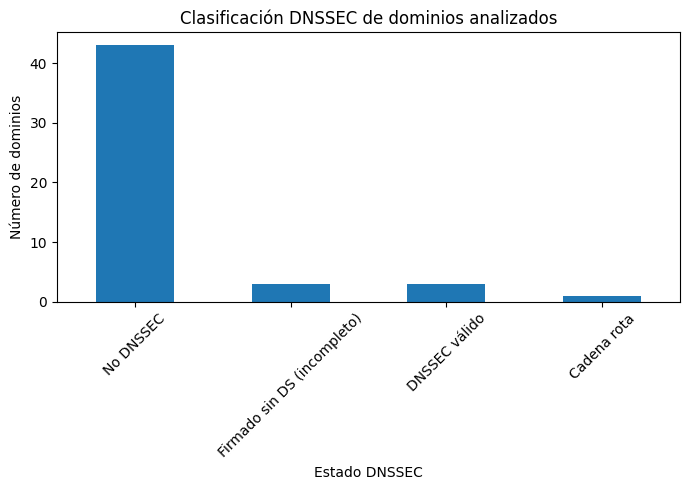

In [23]:
plt.figure(figsize=(7, 5))
state_counts.plot(kind='bar')
plt.title('Clasificación DNSSEC de dominios analizados')
plt.ylabel('Número de dominios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. 🧱 Heatmap simple: Estado DNSSEC por sector

In [24]:
# Tabla cruzada sector vs estado
pivot = pd.crosstab(df['Sector'], df['Estado DNSSEC'])
pivot

Estado DNSSEC,Cadena rota,DNSSEC válido,Firmado sin DS (incompleto),No DNSSEC
Sector,,,,
Bancos,0,0,0,4
Educación,0,1,2,4
Energía / Empresa productiva,0,1,0,0
Gobierno,0,1,1,6
Organismo público financiero / ciencia,1,0,0,2
Otros,0,0,0,12
Retail / Comercio,0,0,0,7
Tecnología / Servicios digitales,0,0,0,2
Telecom / ISP,0,0,0,6


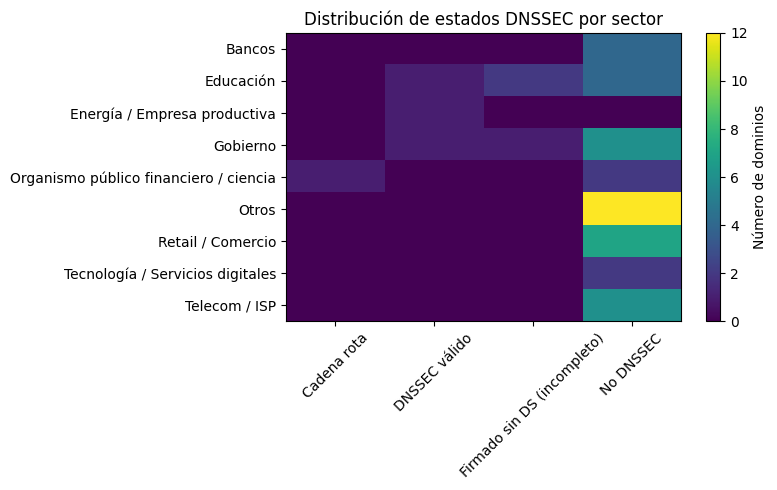

In [25]:
plt.figure(figsize=(8, 5))
plt.imshow(pivot.values, aspect='auto')
plt.colorbar(label='Número de dominios')
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title('Distribución de estados DNSSEC por sector')
plt.tight_layout()
plt.show()

## 5. 🏆 Ranking de seguridad por sector

In [26]:
# Definimos un score sencillo por dominio
score_map = {
    'DNSSEC válido': 2,
    'Firmado sin DS (incompleto)': 1,
    'Cadena rota': 0,
    'No DNSSEC': 0
}

df['Score_seguridad'] = df['Estado DNSSEC'].map(score_map).fillna(0)
sector_scores = df.groupby('Sector')['Score_seguridad'].mean().sort_values(ascending=False)
sector_scores

Sector
Energía / Empresa productiva              2.000000
Educación                                 0.571429
Gobierno                                  0.375000
Bancos                                    0.000000
Organismo público financiero / ciencia    0.000000
Otros                                     0.000000
Retail / Comercio                         0.000000
Tecnología / Servicios digitales          0.000000
Telecom / ISP                             0.000000
Name: Score_seguridad, dtype: float64

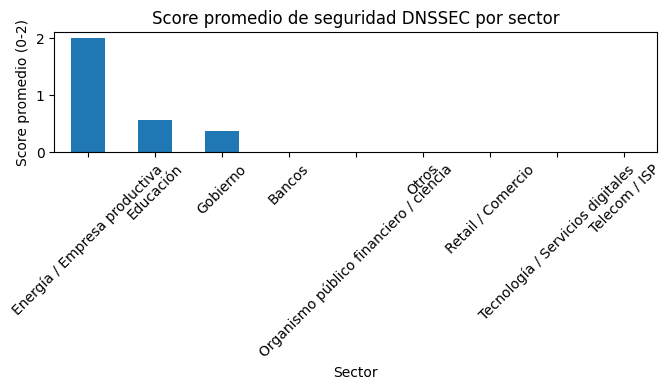

In [27]:
plt.figure(figsize=(7, 4))
sector_scores.plot(kind='bar')
plt.title('Score promedio de seguridad DNSSEC por sector')
plt.ylabel('Score promedio (0-2)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. 🔐 Distribución de algoritmos criptográficos usados en DNSKEY

In [28]:
algos = []
for entry in data:
    for k in entry.get('dnskey', []):
        algo_name = k.get('algorithm_name')
        if algo_name:
            algos.append(algo_name)

algo_counts = Counter(algos)
algo_counts

Counter({'RSA/SHA-256': 7,
         'RSASHA1-NSEC3-SHA1': 6,
         'ECDSA P-256/SHA-256': 5,
         'RSA/SHA-512': 2})

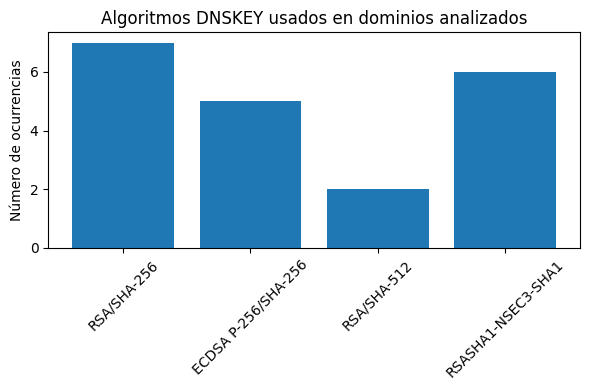

In [29]:
if algo_counts:
    plt.figure(figsize=(6, 4))
    plt.bar(list(algo_counts.keys()), list(algo_counts.values()))
    plt.title('Algoritmos DNSKEY usados en dominios analizados')
    plt.ylabel('Número de ocurrencias')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('No se encontraron DNSKEY en los datos.')

## 7. ⏱️ Análisis simple de TTL para posibles misconfiguraciones

Ejemplo: Revisamos TTL de registros `A` y `AAAA` para ver valores muy bajos o muy altos.


In [30]:
ttl_rows = []
for entry in data:
    domain = entry.get('domain')
    ttl_stats = entry.get('ttl_stats', {})
    for rtype in ['A', 'AAAA', 'NS', 'MX']:
        stats = ttl_stats.get(rtype)
        if stats:
            ttl_rows.append({
                'Dominio': domain,
                'Tipo': rtype,
                'TTL_min': stats.get('min'),
                'TTL_max': stats.get('max'),
                'TTL_avg': stats.get('avg'),
            })

ttl_df = pd.DataFrame(ttl_rows)
ttl_df.head()

,Dominio,Tipo,TTL_min,TTL_max,TTL_avg
0,google.com.mx,A,30,186161,74545.9
1,google.com.mx,AAAA,19,186161,82759.0
2,google.com.mx,NS,345600,345600,345600.0
3,google.com.mx,MX,300,300,300.0
4,sat.gob.mx,A,108,108,108.0


### 7.1 Dominios con TTL muy bajo en A/AAAA (por ejemplo < 60 segundos)

In [31]:
low_ttl = ttl_df[(ttl_df['Tipo'].isin(['A', 'AAAA'])) & (ttl_df['TTL_min'] < 60)]
low_ttl.sort_values(['TTL_min']).head(20)

,Dominio,Tipo,TTL_min,TTL_max,TTL_avg
89,walmart.com.mx,AAAA,6,6,6.000000
88,walmart.com.mx,A,8,8,8.000000
52,conacyt.mx,A,9,9,9.000000
108,totalplay.com.mx,A,12,3579,1323.727273
109,totalplay.com.mx,AAAA,14,21,17.500000
1,google.com.mx,AAAA,19,186161,82759.000000
74,santander.com.mx,A,20,58866,37138.714286
70,bbva.mx,A,20,57525,22125.153846
152,trivago.com.mx,AAAA,20,88706,44112.125000
151,trivago.com.mx,A,20,89528,46650.875000


### 7.2 Dominios con TTL muy alto en A/AAAA (por ejemplo > 86400 segundos)

In [32]:
high_ttl = ttl_df[(ttl_df['Tipo'].isin(['A', 'AAAA'])) & (ttl_df['TTL_max'] > 86400)]
high_ttl.sort_values(['TTL_max'], ascending=False).head(20)

,Dominio,Tipo,TTL_min,TTL_max,TTL_avg
121,diariodequeretaro.com.mx,AAAA,60,186237,62105.583333
0,google.com.mx,A,30,186161,74545.900000
1,google.com.mx,AAAA,19,186161,82759.000000
120,diariodequeretaro.com.mx,A,60,186120,93086.250000
151,trivago.com.mx,A,20,89528,46650.875000
152,trivago.com.mx,AAAA,20,88706,44112.125000


## 8. 🧾 Exportar resumen a CSV

In [33]:
df.to_csv('dnssec_resumen_extendido.csv', index=False)
print('Archivo dnssec_resumen_extendido.csv guardado.')
df.head()

Archivo dnssec_resumen_extendido.csv guardado.


,Dominio,Estado DNSSEC,Sector,Tiene DS,chain_status,Algoritmos DNSKEY,Score_seguridad
0,google.com.mx,No DNSSEC,Tecnología / Servicios digitales,False,no_dnssec,N/A,0
1,gobierno.gob.mx,No DNSSEC,Gobierno,False,broken,N/A,0
2,sat.gob.mx,No DNSSEC,Gobierno,False,no_dnssec,N/A,0
3,imss.gob.mx,No DNSSEC,Gobierno,False,no_dnssec,N/A,0
4,issste.gob.mx,No DNSSEC,Gobierno,False,no_dnssec,N/A,0
